# Attention

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


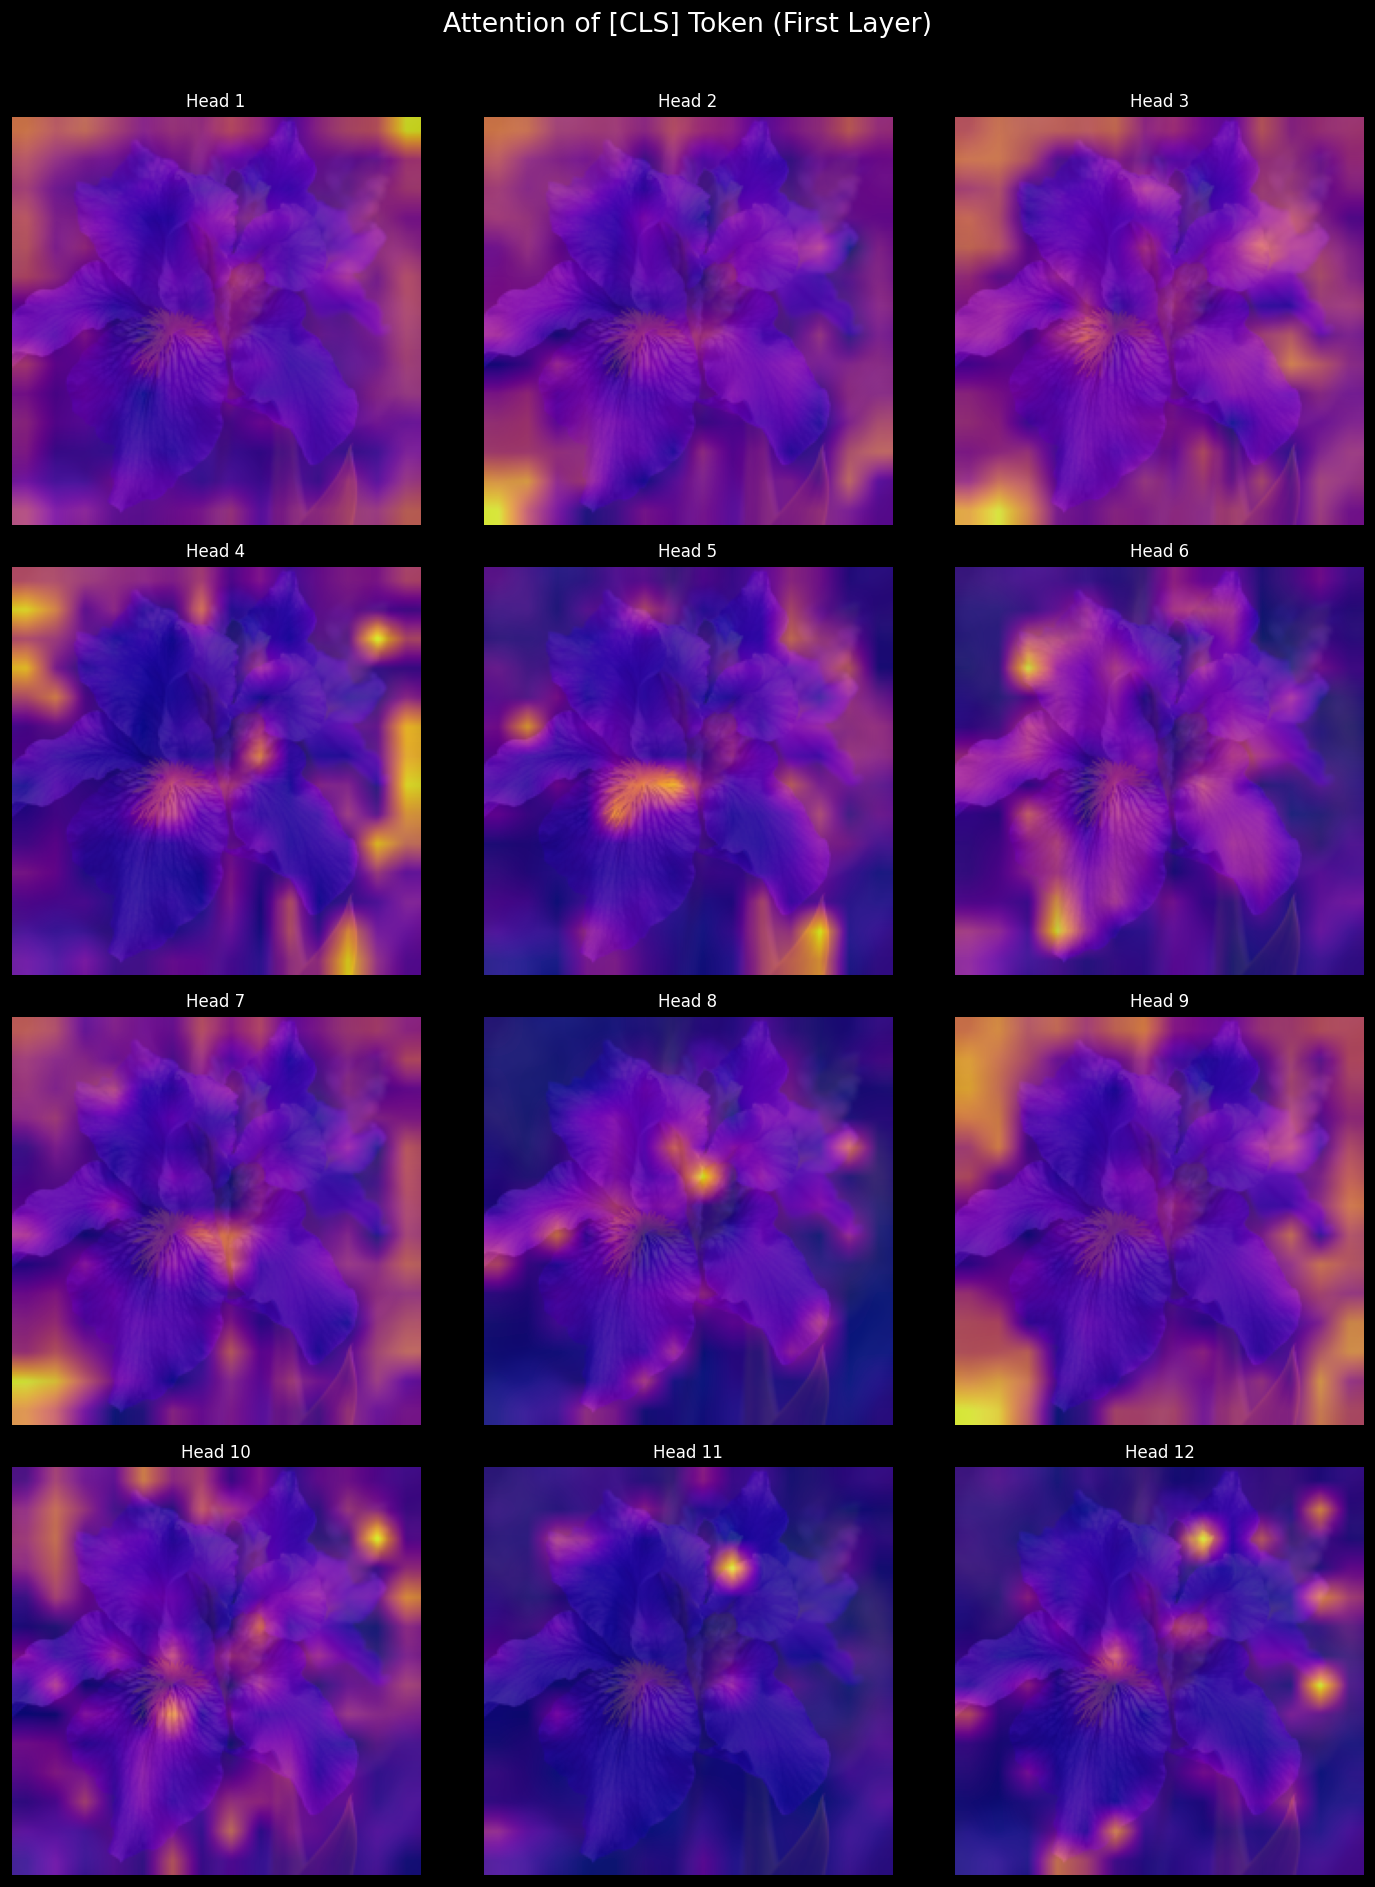

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from PIL import Image
from transformers import ViTImageProcessor, ViTModel

# --- Config ---
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
# MODEL_NAME = "google/vit-base-patch16-224-in21k"
MODEL_NAME = "google/vit-base-patch16-224"
IMAGE_PATH = "/Users/deburky/Documents/python/llm-rag/images/image.png"

# Load model and image
image = Image.open(IMAGE_PATH).convert("RGB").resize((224, 224))
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model = ViTModel.from_pretrained(MODEL_NAME, output_attentions=True).to(DEVICE)
model.eval()

# Inputs
inputs = processor(images=image, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = model(**inputs)

# CLS to patch tokens attention
attn = outputs.attentions[0]  # shape: (1, 12, 197, 197)
attn_cls = attn[0, :, 0, 1:]  # shape: (12, 196)

# Grid
plt.style.use("dark_background")
fig, axes = plt.subplots(4, 3, figsize=(12, 16), dpi=120)
axes = axes.flatten()

for i in range(12):
    # Normalize attention map
    attn_map = attn_cls[i].reshape(14, 14).detach().cpu().numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    # Upsample attention map
    attn_tensor = torch.tensor(attn_map).unsqueeze(0).unsqueeze(0)  # (1, 1, 14, 14)
    attn_upsampled = F.interpolate(
        attn_tensor, size=(224, 224), mode="bilinear", align_corners=False
    )
    attn_upsampled = attn_upsampled.squeeze().numpy()

    # Plot
    ax = axes[i]
    ax.imshow(image)
    ax.imshow(attn_upsampled, cmap="plasma", alpha=0.8)
    ax.set_title(f"Head {i + 1}", fontsize=10)
    ax.axis("off")

plt.suptitle("Attention of [CLS] Token (First Layer)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()